# PINN Implementation
This Jupyter notebook attempts to incorporate a general PINN algorithm, generally made from different sources that I have found, focussing on the development of the neural network using PyTorch.\\
All papers are to be accurately cited for bits of codes that I have extracted, although it will be done with the doi or arXiV ID since footnotes on VS code are not possible. The library that I use, as mentioned in the paper is DeepXDE (doi:10.1137/19M1274067). Code written has been inspired by the written examples provided by the DeepXDE team at https://deepxde.readthedocs.io/en/.


## Environment Setup

In [1]:
from PIL import Image

import sys
!{sys.executable} -m pip install deepxde

%env  DDE_BACKEND=pytorch

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import deepxde as dde



torch.manual_seed(1234)
np.random.seed(1234)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 13.8 MB/s eta 0:00:00
env: DDE_BACKEND=pytorch


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


## Solving the Poisson Equation
### In 1D
We will first solve the 1D Poisson equation through training and compare it with the FDM method and the actual solution. This part comes from the paper regarding GRINN ( 	arXiv:2308.08010). Note that this part was written as an exercise, and is almost identical to that from GRINN. Work here was not used in the dissertation. The Poisson equation is given as
$$
\nabla^2\phi=4\pi G \rho
$$
which could also be expressed as
$$
\begin{align*}
\nabla\phi &= -\mathbf{g}\\
\nabla\cdot\mathbf{g} &= -4\pi G \rho.
\end{align*}
$$
The density is given by
$$
\rho=\rho_1\cos(2\pi x/\lambda)
$$
with periodic boundary conditions
$$
\begin{align*}
\phi(x=x_{\mathrm{min}})&=\phi(x=x_{\mathrm{max}})\\
\partial_x\phi(x=x_{\mathrm{min}})&=\partial_x\phi(x=x_{\mathrm{max}}).
\end{align*}
$$

In [ ]:
## We test the solution of the POISSON's EQN
#Set data type
DTYPE=torch.float32
torch.set_default_dtype(DTYPE)

lam = 1.0          # one wavelength
const = 1 ## we set 4 pi G  tp 1
num_of_waves = 2

rho_1 = 0.03;       # question 2b non-linear wave propagation
rho_o = 1          # zeroth order density
def pdeTest(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return dy_xx - const*(rho_1 * torch.cos(2*np.pi*x/lam))

Compiling model...
'compile' took 0.309048 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [5.97e-02, 3.60e-01, 3.60e-01, 0.00e+00, 0.00e+00]    [5.97e-02, 3.60e-01, 3.60e-01, 0.00e+00, 0.00e+00]    []  
1000      [3.70e-04, 3.27e-10, 3.27e-10, 4.03e-07, 4.03e-07]    [3.70e-04, 3.27e-10, 3.27e-10, 4.03e-07, 4.03e-07]    []  
2000      [3.22e-04, 8.10e-12, 8.10e-12, 3.05e-07, 3.05e-07]    [3.22e-04, 8.10e-12, 8.10e-12, 3.05e-07, 3.05e-07]    []  
3000      [1.74e-04, 1.66e-09, 1.66e-09, 3.44e-08, 3.44e-08]    [1.74e-04, 1.66e-09, 1.66e-09, 3.44e-08, 3.44e-08]    []  

Best model at step 3000:
  train loss: 1.74e-04
  test loss: 1.74e-04
  test metric: []

'train' took 29.131994 s

Compiling model...
'compile' took 0.000478 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
30

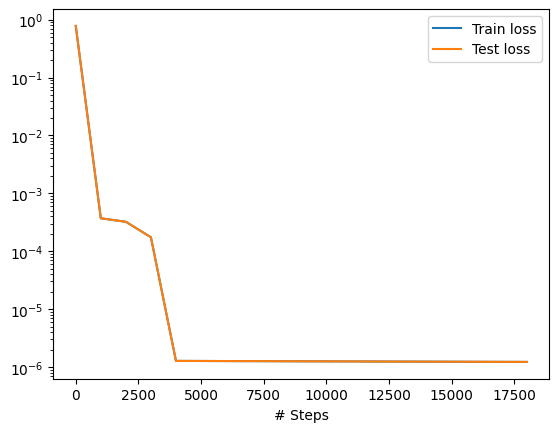

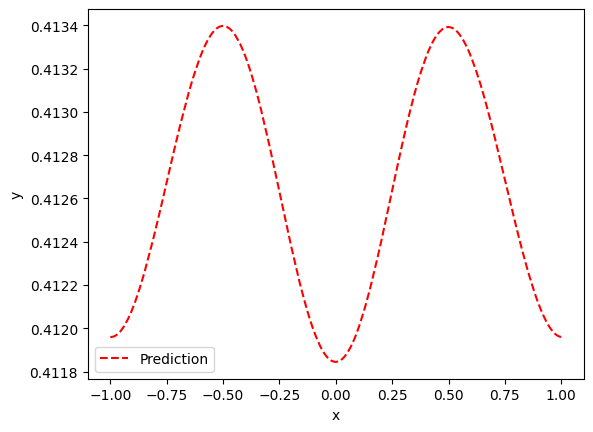

In [ ]:
## The Geometric Domain
xmin = -1
xmax = xmin + lam * num_of_waves
geom = dde.geometry.Interval(xmin, xmax)
#geom = dde.geometry.Interval(-1, 1)


## Boundaries

## Note in the deep XDE code by default for the periodic boundary u(0) = u(1)
## If the problem is periodic this condition will also satisfy u(-1) = u(1)
## Thus is most cases the left boundary is not needed. But we have the option here

def boundary_l(x, on_boundary):  # boundary x=-1 or x = 0
    if xmin == -1:
        is_on_boundary_left = on_boundary and np.isclose(x[0], xmin)
    else:
        is_on_boundary_left = on_boundary and np.isclose(x[0], 0)
    return is_on_boundary_left

def boundary_r(x, on_boundary):  # boundary x=1
    is_on_boundary_right = on_boundary and np.isclose(x[0], xmax)

    return is_on_boundary_right


bc_l = dde.icbc.PeriodicBC(geom, 0, boundary_l,derivative_order=0) ## may be used when x = [-1,1] otherwise for x =[0,1] not needed
bc_r = dde.icbc.PeriodicBC(geom, 0, boundary_r,derivative_order=0)

## 1st order terms

bc_ll = dde.icbc.PeriodicBC(geom, 0, boundary_l,derivative_order=1) ##may be used when x = [-1,1]
bc_rr = dde.icbc.PeriodicBC(geom, 0, boundary_r,derivative_order=1)

data = dde.data.TimePDE(geom,
                     pdeTest,
                     [bc_l,bc_r,bc_ll,bc_rr], ## This is needed if one need to force periodicity on the left
#                     [bc_r,bc_rr],          ## For x =[0,1] and default
                     num_domain=10000,
                     num_boundary=5000
                     #num_initial=5000,
                    # num_test=10000,
                   )

net = dde.nn.FNN([1] + [32] * 3 + [1], "sin", "Glorot normal")
model_test = dde.Model(data, net)

model_test.compile("adam", lr=1e-3)
model_test.train(iterations=3000)
model_test.compile("L-BFGS")


losshistory, train_state = model_test.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

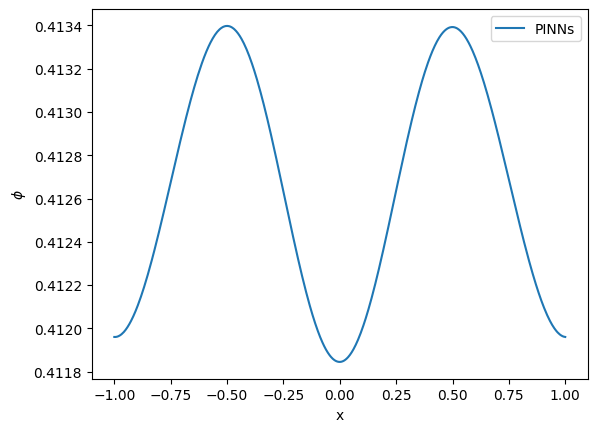

In [ ]:
X = np.linspace(xmin,xmax,1000).reshape(1000, 1)
output_0 = model_test.predict(X)
plt.plot(X,output_0,label="PINNs")
plt.ylabel(r"$\phi$")
plt.xlabel("x")
plt.legend()

Now for the classic interpretation:

In [ ]:
def fft_solver(rho,Lx,N, dim = None):

    '''
    A FFT solver that uses discrete Fast Fourier Transform to
    solve the poisson Equation:
    We apply the correction due to the finite difference grid of phi

    Input: 1. The source function: density in this case
           2. # of grid point N
           3. Domain Size in each dimension

    Output: the potential phi and the field g

    '''
    nx = N
    Lx = Lx

    dx = Lx / nx


    # Calculate the Fourier modes of the gas density
    rhohat = fft(rho)

    # Calculate the wave numbers in x and y directions
    kx = 2 * np.pi * np.fft.fftfreq(nx, dx)
    #ky = 2 * np.pi * np.fft.fftfreq(ny, dy)

    # Construct the Laplacian operator in Fourier space
    kx2 = np.meshgrid(kx**2)

#     laplace = -(kx**2 )
    ## Laplace with the correction refer to the notes
    laplace = 2*(np.cos(kx*dx)-1)

    ## Inorder to avoid the inf we replace zero with a small number
    laplace[laplace == 0] = 1e-16

    # Solve for the gravitationa potential in Fourier space
    phihat = rhohat / laplace

    phihat = rhohat * dx**2/laplace
#     window = signal.windows.tukey(len(phihat),alpha=0.25)


    # Transform back to real space to obtain the solution
#     phi = np.real(ifft(phihat*window))
    phi = np.real(ifft(phihat))

    ## The field ,i.e., gravity
    dphidx = np.gradient(phi, dx)

    return phi,dphidx

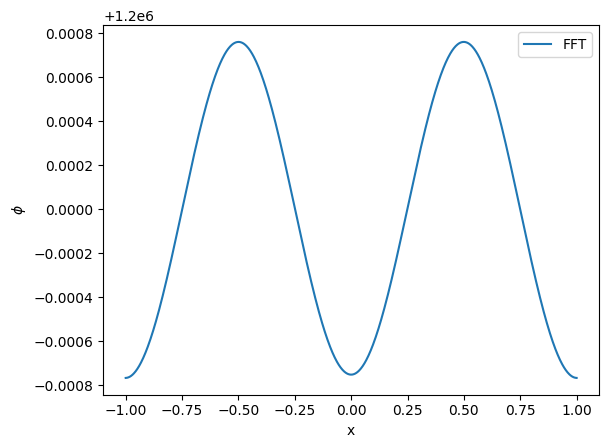

In [ ]:
from numpy.fft import fft, ifft
from scipy import signal
L = lam * num_of_waves
N = 1000
x = np.linspace(1-L, L-1, N)
rho = rho_1 * np.cos(2*np.pi*x/lam)

phi, dpidx  = fft_solver(const*(rho),L,N, dim = None)
plt.plot(x,phi,label="FFT")
plt.ylabel(r"$\phi$")
plt.xlabel("x")
plt.legend()

### In 2D
We now solve the above in 2D. It is mostly the same but with an added dimension (UPDATE LATER). This section, as above, is also from the GRINN paper.

In [ ]:
from matplotlib import cm

lam = 1.0          # one wavelength
const = 1 ## we set 4 pi G  tp 1
num_of_waves = 2

rho_1 = 0.03;       # question 2b non-linear wave propagation
rho_o = 1          # zeroth order density
def pdeTest(x, y):
    dy_xx = dde.grad.hessian(y, x,i=0,j=0)

    dy_yy = dde.grad.hessian(y, x,i=1,j=1)

    return dy_xx + dy_yy - const*(rho_1 * torch.cos(2*np.pi*x[:, 0:1]/lam))

Compiling model...
'compile' took 0.398683 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [3.90e-03, 8.43e-02, 1.58e-02, 3.80e-02, 2.27e-03]    [3.90e-03, 8.43e-02, 1.58e-02, 3.80e-02, 2.27e-03]    []  
1000      [4.08e-04, 7.46e-10, 1.31e-08, 2.24e-07, 1.61e-06]    [4.08e-04, 7.46e-10, 1.31e-08, 2.24e-07, 1.61e-06]    []  
2000      [5.01e-05, 7.05e-08, 6.07e-08, 3.36e-07, 1.78e-06]    [5.01e-05, 7.05e-08, 6.07e-08, 3.36e-07, 1.78e-06]    []  
3000      [6.49e-06, 1.88e-08, 1.18e-08, 1.42e-07, 3.68e-07]    [6.49e-06, 1.88e-08, 1.18e-08, 1.42e-07, 3.68e-07]    []  

Best model at step 3000:
  train loss: 7.03e-06
  test loss: 7.03e-06
  test metric: []

'train' took 33.460719 s

Compiling model...
'compile' took 0.000358 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
30

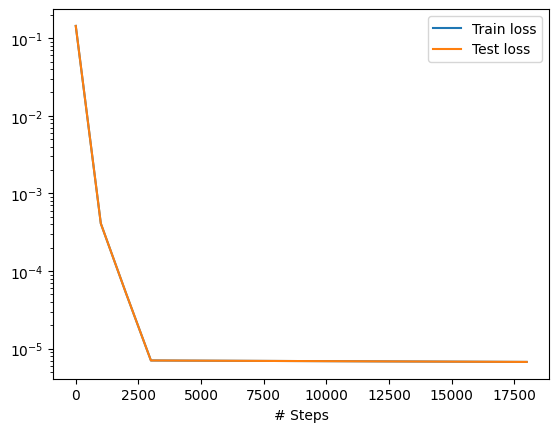

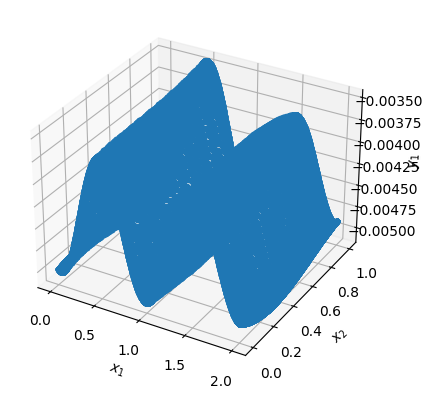

In [ ]:
## The Geometric Domain
xmin = 0
xmax = xmin + lam * num_of_waves


ymin= 0
ymax= 1

# tmax= 3

geom = dde.geometry.Rectangle([xmin, ymin], [xmax, ymax])
# geom = dde.geometry.Interval(xmin, xmax)
# geom = dde.geometry.Interval(-1, 1)


## Boundaries

## Note in the deep XDE code by default for the periodic boundary u(0) = u(1)
## If the problem is periodic this condition will also satisfy u(-1) = u(1)
## Thus is most cases the left boundary is not needed. But we have the option here

def boundary_l(x, on_boundary):  # boundary x=-1 or x = 0
    is_on_boundary_left = on_boundary and np.isclose(x[0], xmin)
    return is_on_boundary_left

def boundary_r(x, on_boundary):  # boundary x=1
    # is_on_boundary_right = on_boundary and np.isclose(x[0], xmax)
    is_on_boundary_right =  np.isclose(x[0], xmax)
    return is_on_boundary_right

def boundary_u(x, on_boundary):  # boundary x=1
    # is_on_boundary_up = on_boundary and np.isclose(x[1], ymax)
    is_on_boundary_up =  np.isclose(x[1], ymax)
    # print(is_on_boundary_up)
    return is_on_boundary_up

def boundary_d(x, on_boundary):  # boundary x=1
    is_on_boundary_lower = on_boundary and np.isclose(x[1], ymin)
    # print(is_on_boundary_up)
    return is_on_boundary_lower


bc_l = dde.icbc.PeriodicBC(geom, 0, boundary_l,derivative_order=0) ## may be used when x = [-1,1] otherwise for x =[0,1] not needed
bc_r = dde.icbc.PeriodicBC(geom, 0, boundary_r,derivative_order=0)

## 1st order terms

bc_ll = dde.icbc.PeriodicBC(geom, 0, boundary_l,derivative_order=1) ##may be used when x = [-1,1]
bc_rr = dde.icbc.PeriodicBC(geom, 0, boundary_r,derivative_order=1)


## Boundaries in 2D:

phixr =  dde.icbc.PeriodicBC(geom, 0, boundary_r,derivative_order=0)
# phixl =  dde.icbc.PeriodicBC(geom, 0, boundary_l,derivative_order=0)

phixrr = dde.icbc.PeriodicBC(geom, 0, boundary_r,derivative_order=1)

phiyu =  dde.icbc.PeriodicBC(geom, 1, boundary_u,derivative_order=0)

phiyuu = dde.icbc.PeriodicBC(geom, 1, boundary_u,derivative_order=1)
# phiyd =  dde.icbc.PeriodicBC(geom, 1, boundary_d,derivative_order=0)



data = dde.data.TimePDE(geom,
                     pdeTest,
                     # [phixr,phiyu], ## This is needed if one need to force periodicity on the left
                     [phixr,phiyu,phixrr,phiyuu],
                        # [phixr,phixl,phiyu,phiyd],          ## For x =[0,1] and default
                     num_domain=10000,
                     num_boundary=5000
                     #num_initial=5000,
                    # num_test=10000,
                   )

net = dde.nn.FNN([2] + [32] * 3 + [1], "sin", "Glorot normal")
model_test = dde.Model(data, net)

model_test.compile("adam", lr=1e-3)
model_test.train(iterations=3000)
model_test.compile("L-BFGS")


losshistory, train_state = model_test.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

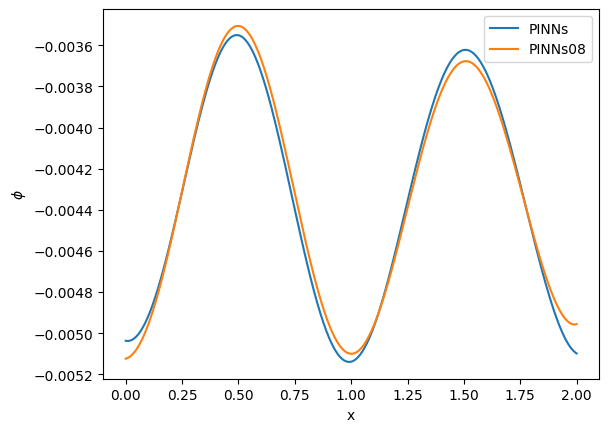

In [ ]:
## Plotting at y= 0.5 and  y= 0.8 slice

X = np.linspace(xmin,xmax,1000).reshape(1000, 1)
Y_05 = 0.5*np.ones(1000).reshape(1000, 1)
Y_08 = 0.8*np.ones(1000).reshape(1000, 1)

X_05 = np.hstack((X, Y_05))
X_08 = np.hstack((X, Y_08))
output_05 = model_test.predict(X_05)
output_08 = model_test.predict(X_08)


plt.plot(X,output_05,label="PINNs")
plt.plot(X,output_08,label="PINNs08")
plt.ylabel(r"$\phi$")
plt.xlabel("x")
plt.legend()

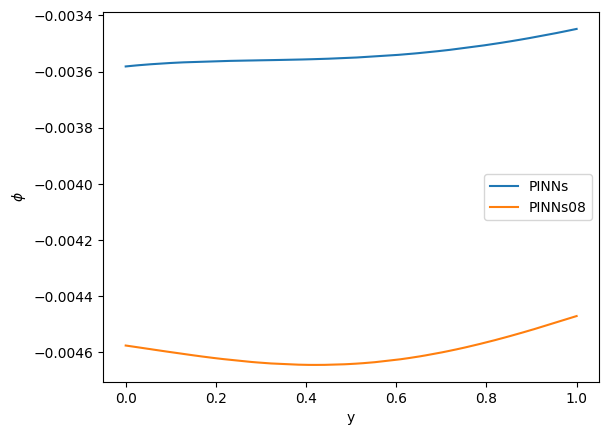

In [ ]:
## Plotting at x= 0.5 and  x= 0.8 slice
X = np.linspace(xmin,xmax,1000).reshape(1000)

Y = np.linspace(0,ymax,1000).reshape(1000, 1)
X_05 = 0.5*np.ones(1000).reshape(1000, 1)
X_08 = 0.8*np.ones(1000).reshape(1000, 1)

Y_05 = np.hstack((X_05, Y))
Y_08 = np.hstack((X_08, Y))
output_Y05 = model_test.predict(Y_05)
output_Y08 = model_test.predict(Y_08)


plt.plot(Y,output_Y05,label="PINNs")
plt.plot(Y,output_Y08,label="PINNs08")
plt.ylabel(r"$\phi$")
plt.xlabel("y")
plt.legend()

(400, 2)
(20, 20)
(20, 20)


Text(0.5, 0, '$\\phi$')

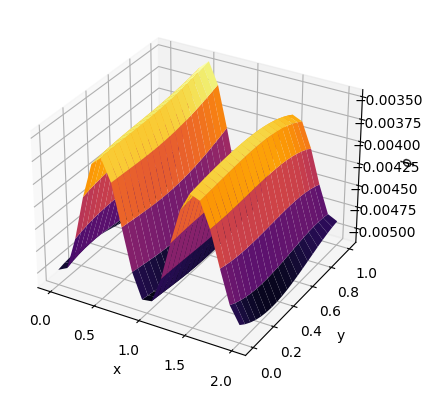

In [ ]:
fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(0, xmax, 20)
ys = np.linspace(0, ymax, 20)
tau, phi = np.meshgrid(xs, ys)
Xgrid = np.vstack([tau.flatten(),phi.flatten()]).T
print(np.shape(Xgrid))
# Z evaluation
# amp = np.sin(tau+phi)
output = model_test.predict(Xgrid)
test = output.reshape(20,20)

print(np.shape(tau))
print(np.shape(test))

surf = ax3d.plot_surface(tau, phi, test,cmap=cm.inferno)
ax3d.set_xlabel("x")
ax3d.set_ylabel("y")
ax3d.set_zlabel(r"$\phi$",labelpad=1)

Finding the analytic solution using fft,

In [ ]:
def fft_solver(rho,Lx,Ly,N, dim = None):

    '''
    A FFT solver that uses discrete Fast Fourier Transform to
    solve the poisson Equation:
    We apply the correction due to the finite difference grid of phi

    Input: 1. The source function: density in this case
           2. # of grid point N
           3. Domain Size in each dimension

    Output: the potential phi and the field g

    '''
    nx = N
    Lx = Lx
    ny =nx
    dx = Lx / nx
    dy = Ly / nx

    # Calculate the Fourier modes of the gas density
    rhohat = fft(rho)

    # Calculate the wave numbers in x and y directions
    kx = 2 * np.pi * np.fft.fftfreq(nx, dx)
    ky = 2 * np.pi * np.fft.fftfreq(ny, dy)

#     # Construct the Laplacian operator in Fourier space
#     kx2 = np.meshgrid(kx**2)
#     ky2 = np.meshgrid(ky**2)

    # Construct the Laplacian operator in Fourier space
    kx2, ky2 = np.meshgrid(kx**2, ky**2)
    laplace = -(kx2 + ky2)

    laplace[laplace == 0] = 1e-16

    # Solve for the gravitationa potential in Fourier space
    phihat = rhohat / laplace

    phihat = rhohat * dx**2/laplace
#     window = signal.windows.tukey(len(phihat),alpha=0.25)


    # Transform back to real space to obtain the solution
#     phi = np.real(ifft(phihat*window))
    phi = np.real(ifft(phihat))

    ## The field ,i.e., gravity
    dphidx = np.gradient(phi, dx)

    dphidy = np.gradient(phi, dy)
    return phi,dphidx, dphidy

In [ ]:
import numpy as np
from numpy.fft import fft2, ifft2
from matplotlib import cm
import matplotlib.pyplot as plt


# Define the problem domain and grid spacing
Lx, Ly = 2.0, 1.0
nx, ny = 128, 128
dx, dy = Lx / nx, Ly / ny

# Define the charge density rho(x,y)
x, y = np.meshgrid(np.linspace(0, Lx, nx), np.linspace(0, Ly, ny))
#rho = np.sin(2 * np.pi * x) * np.sin(2 * np.pi * y)


xs = np.linspace(0, 2*np.pi, 200)
ys = np.linspace(0, 2*np.pi, 200)
tau, phi = np.meshgrid(xs, ys)
# Z evaluation
# amp = np.sin(tau+phi)
amp = np.sin(tau)

rho = np.cos(2 * np.pi * x)


# Calculate the Fourier modes of the charge density
rhohat = fft2(rho)

# Calculate the wave numbers in x and y directions
kx = 2 * np.pi * np.fft.fftfreq(nx, dx)
ky = 2 * np.pi * np.fft.fftfreq(ny, dy)

# Construct the Laplacian operator in Fourier space
kx2, ky2 = np.meshgrid(kx**2, ky**2)
laplace = -(kx2 + ky2)

laplace[laplace == 0] = 1e-9

# Solve for the electrostatic potential in Fourier space
phihat = rhohat / laplace

# Transform back to real space to obtain the solution
phi = np.real(ifft2(phihat))

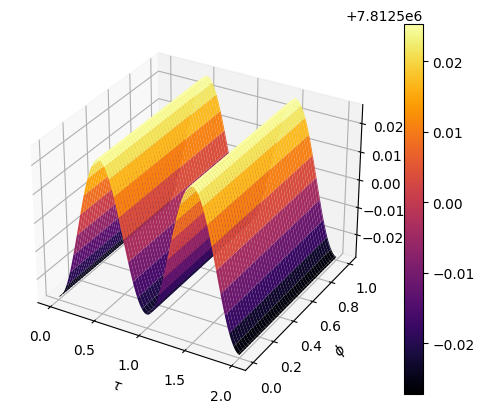

In [ ]:
fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')



ax3d.set_xlabel(r'$\tau$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$\phi$')  # phi -> phase
ax3d.set_zlabel(r'$\Phi$')   # signal amplitude

surf = ax3d.plot_surface(x, y, phi,cmap=cm.inferno)
fig.colorbar(surf)

## Solving the Lame-Emden (LE) Equation for Polytropic Cases
In this section, we solve the different types of LE equations, adopted from the paper of the same title (doi:10.1016/J.ASCOM.2023.100734). The general LE equation for the polytropic case is
$$
\frac{1}{x^2}\frac{d}{dx}\left(x^2\frac{dy(x)}{dx}\right)+y^n=0.
$$

There are only 3 cases for which there is a solution: $n=0,\ n=1,\ n=5$.

For the case of $n=5$, the boundary conditions are
$$
y(0)=1\quad\mathrm{and}\quad y'(0)=0.
$$
We firstly train the model, again using DeepXDE (contrary to the paper). This time, we neglect the use of L-BFGS and use only Adam.

In [2]:
#Set data type
DTYPE=torch.float32
torch.set_default_dtype(DTYPE)

def ode(x, y):
    dy_dx = dde.grad.jacobian(y, x)
    dy_xx = dde.grad.hessian(y,x)
    ind = 5
    return (2*dy_dx+x*dy_xx)+x*y**ind

Compiling model...
'compile' took 0.000506 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.97e-02, 1.00e+00, 1.01e-01]    [2.97e-02, 1.00e+00, 1.01e-01]    []  
1000      [2.46e-05, 6.76e-08, 9.48e-08]    [2.46e-05, 6.76e-08, 9.48e-08]    []  
2000      [7.03e-06, 9.68e-09, 1.31e-08]    [7.03e-06, 9.68e-09, 1.31e-08]    []  
3000      [3.24e-06, 1.79e-09, 2.28e-09]    [3.24e-06, 1.79e-09, 2.28e-09]    []  
4000      [1.23e-06, 3.09e-10, 3.95e-10]    [1.23e-06, 3.09e-10, 3.95e-10]    []  
5000      [4.41e-07, 3.21e-11, 1.08e-09]    [4.41e-07, 3.21e-11, 1.08e-09]    []  
6000      [2.69e-07, 1.03e-12, 4.04e-08]    [2.69e-07, 1.03e-12, 4.04e-08]    []  
7000      [2.14e-07, 5.68e-14, 3.81e-08]    [2.14e-07, 5.68e-14, 3.81e-08]    []  
8000      [1.82e-07, 8.88e-14, 7.67e-10]    [1.82e-07, 8.88e-14, 7.67e-10]    []  
9000      [1.96e-07, 1.74e-13, 1.50e-06]    [1.96e-07, 1.74e-13, 1.50e-06]    []  
10000     [1.42

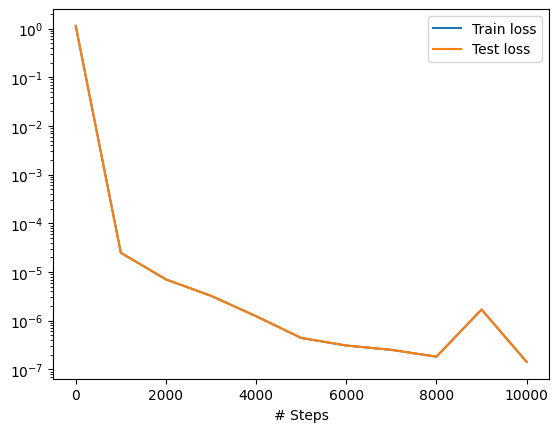

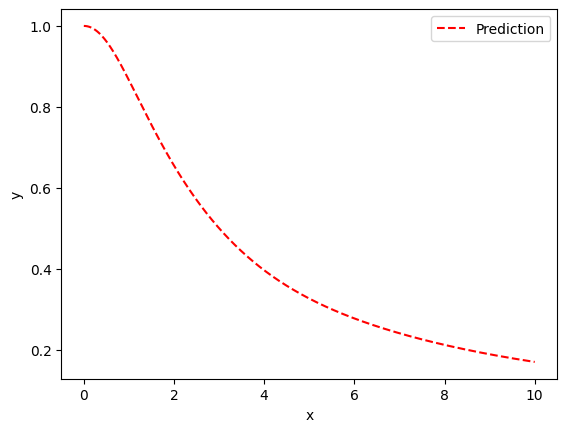

In [8]:
xmin = 0
xmax = 10
geom = dde.geometry.TimeDomain(xmin, xmax)

def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0],0)

def bc_func2(inputs,outputs,X):
    return dde.grad.jacobian(outputs, inputs, i=0, j=None)

ic1 = dde.icbc.IC(geom, lambda x: 1, lambda _, on_initial: on_initial)
ic2 = dde.icbc.OperatorBC(geom, bc_func2, boundary_l)

data = dde.data.TimePDE(geom, ode, [ic1, ic2], 1000, 500) #num_initial=5000, #num_test=10000

layer_size = [1] + [50] * 5 + [1]
net = dde.nn.FNN(layer_size, "tanh", "Glorot normal")

model_test = dde.Model(data, net)
model_test.compile("adam",lr=.0001, loss_weights=[0.01, 1, 1])
losshistory, train_state = model_test.train(iterations=10000)

#dde.optimizers.config.set_LBFGS_options(
#    maxcor=50,
#    ftol=1.0 * np.finfo(float).eps,
#    gtol=1e-08,
#    maxiter=5000,
#    maxfun=10000,
#    maxls=50,
#)
#model_test.compile("L-BFGS")



dde.saveplot(losshistory, train_state, issave=True, isplot=True)

We now compare it with the actual solution,
$$
y(x) = \frac{1}{\sqrt{1+x^2/3}}.
$$

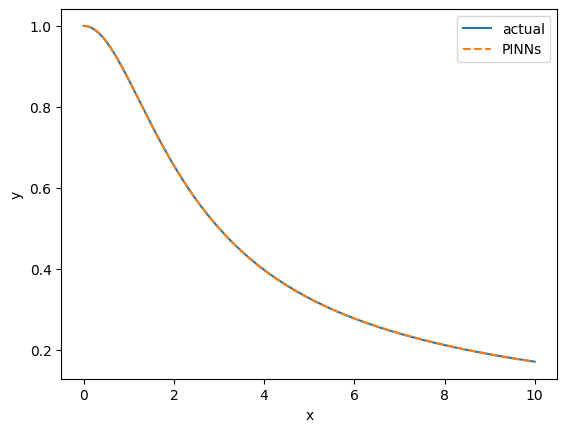

In [9]:
X = np.linspace(xmin,xmax,1000).reshape(1000, 1)
output_0 = model_test.predict(X)

x = np.linspace(0,10,1000)
def f(x):
  return 1/np.sqrt(1+x**2/3)
y=f(x)

plt.plot(x,y,label="actual")
plt.plot(X,output_0,label="PINNs",linestyle="--")
plt.ylabel("y")
plt.xlabel("x")
plt.legend()


0.0011652708053588867


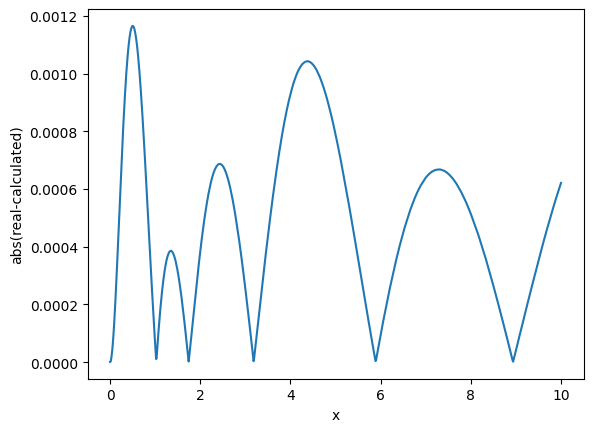

In [10]:
# Error rate
error = np.empty(len(x))

for i in range (0,len(x)):
   error[i] = np.abs(y[i]-output_0[i])
print(max(error))
plt.xlabel("x")
plt.ylabel("abs(real-calculated)")
plt.plot(x,error)
plt.show()

## 1D Wave Equation
Let us now consider a 1D wave equation problem which has the general form
$$
\frac{\partial^2 u}{\partial t^2} = c^2 \nabla^2 u.
$$
We assume that the wave takes place on a square plate, with initial conditions
$$
u(x,0) = \sin(n\pi x/L),\ \frac{\partial u(x,0)}{\partial t} = 0
$$
and with boundary conditions
$$
u(0,t) = 0,\ u(L,t) = 0.
$$

In [11]:
#Set data type
DTYPE=torch.float32
torch.set_default_dtype(DTYPE)

C = 1
n = 1
L=1

geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 10)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

cos = torch.cos

def pde(x, y):
    dy_tt = dde.grad.hessian(y, x, i=1, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    x, t = x[:, 0:1], x[:, 1:2]
    return dy_tt - C**2 * (dy_xx)

def func(x):
    return np.sin(n * np.pi * x[:, 0:1]/L)*np.cos(np.pi/L *C*x[:, 1:2])

Compiling model...
'compile' took 0.000914 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.02e-04, 6.89e-03, 4.09e-01, 6.53e-03]    [1.85e-04, 6.89e-03, 4.09e-01, 6.53e-03]    []  
1000      [1.67e-03, 2.33e-04, 1.13e-04, 5.22e-04]    [1.66e-03, 2.33e-04, 1.13e-04, 5.22e-04]    []  
2000      [1.31e-04, 4.68e-06, 2.70e-05, 2.96e-04]    [1.27e-04, 4.68e-06, 2.70e-05, 2.96e-04]    []  
3000      [1.91e-04, 1.91e-05, 1.45e-05, 2.30e-04]    [1.76e-04, 1.91e-05, 1.45e-05, 2.30e-04]    []  
4000      [7.63e-05, 1.53e-06, 1.07e-05, 1.18e-04]    [7.34e-05, 1.53e-06, 1.07e-05, 1.18e-04]    []  
5000      [5.41e-05, 5.69e-07, 7.10e-06, 7.87e-05]    [5.08e-05, 5.69e-07, 7.10e-06, 7.87e-05]    []  
6000      [4.78e-05, 4.17e-07, 8.31e-06, 6.14e-05]    [4.41e-05, 4.17e-07, 8.31e-06, 6.14e-05]    []  
7000      [4.74e-05, 3.11e-06, 8.33e-06, 6.15e-05]    [4.58e-05, 3.11e-06, 8.33e-06, 6.15e-05]    []  
8

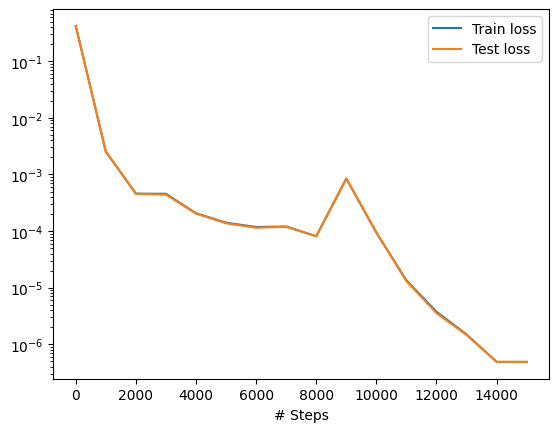

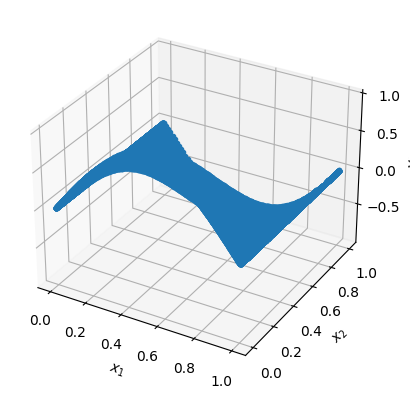

In [12]:
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic_1 = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
ic_2 = dde.icbc.OperatorBC(
    geomtime,
    lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=1),
    lambda _, on_initial: on_initial,
)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic_1, ic_2],
    num_domain=30000,
    num_boundary=1500,
    num_initial=1500,
    solution=func,
    num_test=6000,
)

layer_size = [2] + [50] * 5 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile(
    "adam", lr=0.001, decay=("inverse time", 3000, 0.9)
)
model.train(iterations=10000)


dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=5000,
    maxfun=10000,
    maxls=50,
)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


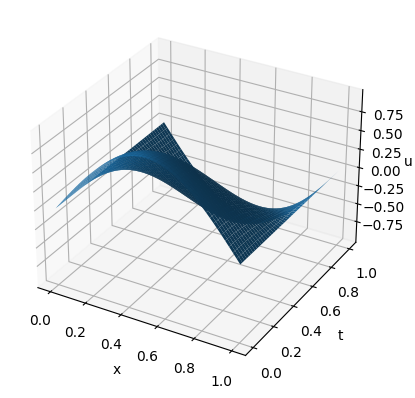

In [13]:
fig = plt.figure()
ax = plt.axes(projection="3d")

x = x = np.linspace(0,1,1000)
t = x = np.linspace(0,1,1000)
x, t = np.meshgrid(x,t)

def f(x,t):
  return np.sin(n * np.pi * x/L)*np.cos(np.pi/L *C*t)
u = f(x,t)

ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u",labelpad=1)
surf = ax.plot_surface(x, t, u)


(1000000, 2)


Text(0.5, 0, 'u')

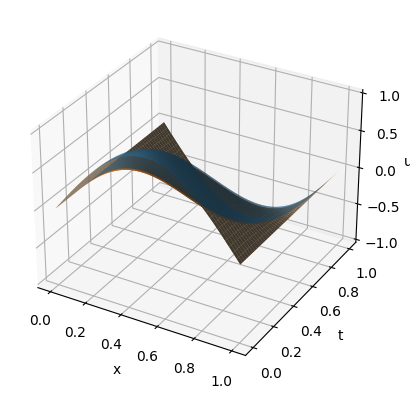

In [14]:
fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

xs = np.linspace(0, 1, 1000)
ts = np.linspace(0, 1, 1000)
xs, ts = np.meshgrid(xs, ts)
Xgrid = np.vstack([xs.flatten(),ts.flatten()]).T
print(np.shape(Xgrid))
# Z evaluation
output = model.predict(Xgrid)
us = output.reshape(1000,1000)
surf = ax3d.plot_surface(xs, ts, us, alpha=0.5)
surf2 = ax3d.plot_surface(x,t,u, alpha=1)
ax3d.set_xlabel("x")
ax3d.set_ylabel("t")
ax3d.set_zlabel("u",labelpad=1)

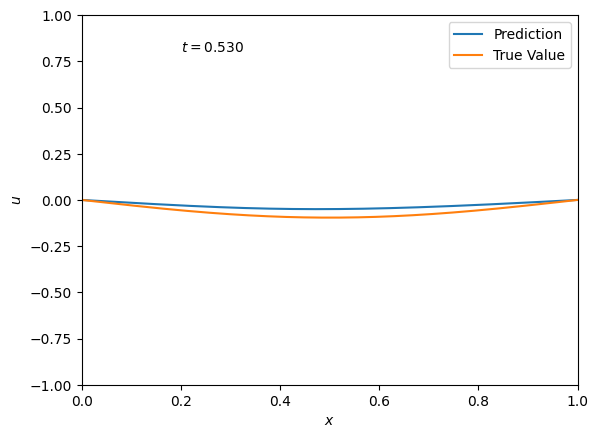

In [66]:
plt.xlim(0,1)
plt.ylim(-1,1)

plt.xlabel(f"$x$")
plt.ylabel(f"$u$")
plt.text(0.2,0.8,f"$t=0.530$")
plt.plot(xs[5,:],us[530,:], label='Prediction')
plt.plot(xs[5,:],u[530,:], label='True Value')
plt.legend()

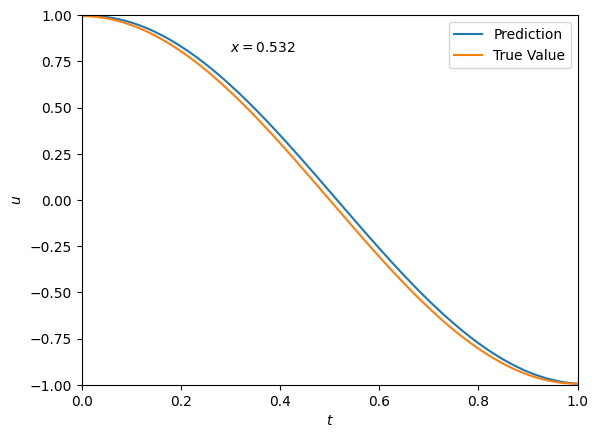

In [69]:
plt.xlim(0,1)
plt.ylim(-1,1)

plt.xlabel(f"$t$")
plt.ylabel(f"$u$")
plt.text(0.3,0.8,f"$x=0.532$")
plt.plot(ts[:,5],us[:,532], label='Prediction')
plt.plot(ts[:,5],u[:,532], label='True Value')
plt.legend()

[[530 532]]
0.04632025587349488


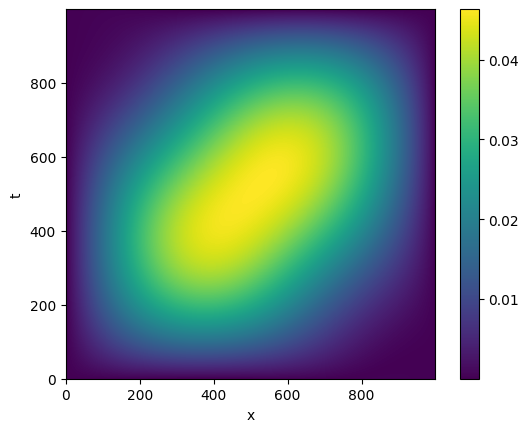

In [70]:
import matplotlib
import matplotlib as mpl

cont = np.ndarray(shape=(1000,1000))

for i in range(1000):
  for j in range(1000):
    cont[i,j] = np.abs(u[i,j]-us[i,j])

#print("max x",max(cont[:,]) )
#print("max t",max(cont[,:]) )

print(np.argwhere(np.amax(cont)==cont))
print(np.amax(cont))
print()

fig, ax = plt.subplots()

ax = plt.imshow(cont, origin='lower')

plt.xlabel('x')
plt.ylabel('t')
plt.colorbar(ax)

plt.show()